# Configure Preprocessing Params (GCS Version)

This notebook is adapted to work with data in Google Cloud Storage.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path
import yaml
import pandas as pd
import subprocess
import re
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_metadata, convert_to_array
from lib.preprocess.file_utils import get_sample_fps, get_tile_count_from_well

## GCS Helper Functions

These functions enable working with files stored in Google Cloud Storage:

In [2]:
def list_gcs_files(gcs_path, pattern="*"):
    """List files in GCS bucket matching a pattern."""
    if gcs_path is None:
        return []
    
    if not gcs_path.endswith("/"):
        gcs_path += "/"
    
    cmd = ["gsutil", "ls", "-r", gcs_path]
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Error listing GCS files: {result.stderr}")
        return []
    
    all_files = [line.strip() for line in result.stdout.split("\n") if line.strip()]
    pattern_regex = pattern.replace("*", ".*").replace("?", ".")
    matched_files = [
        f for f in all_files 
        if f.startswith("gs://") and not f.endswith(":") and re.search(pattern_regex, f)
    ]
    
    return matched_files


def create_samples_df_gcs(images_dir_fp, path_pattern, path_metadata, metadata_order_type, 
                          file_pattern="*", strip_bucket_prefix=None):
    """Create samples DataFrame from GCS files (mimics create_samples_df).
    
    Args:
        images_dir_fp: GCS path to image directory (e.g., gs://bucket/path/)
        path_pattern: Regex pattern to match file paths
        path_metadata: List of metadata fields to extract
        metadata_order_type: Dict mapping field names to type converters
        file_pattern: Pattern for filtering files (default: "*")
        strip_bucket_prefix: GCS bucket prefix to strip (e.g., "gs://scale1/"). 
                           Set this for batch processing to create relative paths.
                           
    Returns:
        DataFrame with sample_fp and extracted metadata columns
    """
    if images_dir_fp is None or path_pattern is None:
        return pd.DataFrame()
    
    files = list_gcs_files(images_dir_fp, file_pattern)
    if not files:
        return pd.DataFrame()
    
    records = []
    pattern = re.compile(path_pattern)
    
    for file_path in files:
        match = pattern.search(file_path)
        if match:
            # Strip bucket prefix if specified (for batch processing)
            sample_fp = file_path
            if strip_bucket_prefix and file_path.startswith(strip_bucket_prefix):
                sample_fp = file_path.replace(strip_bucket_prefix, "", 1)
            
            record = {"sample_fp": sample_fp}
            for i, field in enumerate(path_metadata):
                value = match.group(i + 1)
                if field in metadata_order_type:
                    value = metadata_order_type[field](value)
                record[field] = value
            records.append(record)
    
    if not records:
        return pd.DataFrame()
    
    df = pd.DataFrame(records)
    column_order = ["sample_fp"] + path_metadata
    df = df[column_order]
    df = df.sort_values(by=path_metadata).reset_index(drop=True)
    
    return df


def download_gcs_samples(samples_df, metadata_df=None, output_dir="gcs_temp", 
                         n_tiles=1, n_channels=3, gcs_bucket_prefix="gs://scale1/"):
    """
    Download a subset of sample files from GCS for local testing.
    
    Args:
        samples_df: DataFrame with GCS sample file paths (relative or full URIs)
        metadata_df: Optional DataFrame with metadata file paths
        output_dir: Local directory to download files to
        n_tiles: Number of tiles to download
        n_channels: Number of channels to download per tile
        gcs_bucket_prefix: GCS bucket prefix to prepend if paths are relative (e.g., "gs://scale1/")
        
    Returns:
        tuple: (samples_local, metadata_local) DataFrames with local file paths
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    path_mapping = {}
    
    # Helper function to ensure full GCS URI
    def get_full_gcs_path(path):
        if path.startswith("gs://"):
            return path
        else:
            return gcs_bucket_prefix + path
    
    # Select a subset of tiles
    if "tile" in samples_df.columns:
        unique_tiles = samples_df[["plate", "well", "tile"]].drop_duplicates()
        sample_tiles = unique_tiles.head(n_tiles)
        
        for _, tile_info in sample_tiles.iterrows():
            print(f"Downloading tile: plate={tile_info['plate']}, well={tile_info['well']}, tile={tile_info['tile']}")
            
            # Filter for this tile
            tile_mask = (
                (samples_df["plate"] == tile_info["plate"]) &
                (samples_df["well"] == tile_info["well"]) &
                (samples_df["tile"] == tile_info["tile"])
            )
            tile_samples = samples_df[tile_mask]
            
            # Sample channels if present
            if "channel" in tile_samples.columns:
                unique_channels = tile_samples["channel"].unique()
                sample_channels = unique_channels[:n_channels]
                tile_samples = tile_samples[tile_samples["channel"].isin(sample_channels)]
            
            # Download each file
            for _, row in tile_samples.iterrows():
                relative_path = row["sample_fp"]
                gcs_path = get_full_gcs_path(relative_path)
                
                # Preserve structure: gs://bucket/path/file -> gcs_temp/path/file
                path_without_prefix = gcs_path.replace("gs://", "").split("/", 1)[1]
                local_path = output_dir / path_without_prefix
                local_path.parent.mkdir(parents=True, exist_ok=True)
                
                cmd = ["gsutil", "cp", gcs_path, str(local_path)]
                result = subprocess.run(cmd, capture_output=True, text=True)
                
                if result.returncode == 0:
                    path_mapping[relative_path] = str(local_path)
                    print(f"  ✓ {local_path.name}")
                else:
                    print(f"  ✗ Failed: {gcs_path}")
    
    # Download metadata files
    if metadata_df is not None and len(metadata_df) > 0:
        print("Downloading metadata files...")
        for _, row in metadata_df.iterrows():
            relative_path = row["sample_fp"]
            gcs_path = get_full_gcs_path(relative_path)
            
            path_without_prefix = gcs_path.replace("gs://", "").split("/", 1)[1]
            local_path = output_dir / path_without_prefix
            local_path.parent.mkdir(parents=True, exist_ok=True)
            
            cmd = ["gsutil", "cp", gcs_path, str(local_path)]
            result = subprocess.run(cmd, capture_output=True, text=True)
            
            if result.returncode == 0:
                path_mapping[relative_path] = str(local_path)
                print(f"  ✓ {local_path.name}")
    
    print(f"\n✓ Downloaded {len(path_mapping)} files to {output_dir}/")
    
    # Update sample_fp in DataFrames to point to local paths
    samples_local = samples_df.copy()
    samples_local["sample_fp"] = samples_local["sample_fp"].map(lambda x: path_mapping.get(x, x))
    samples_local = samples_local[samples_local["sample_fp"].isin(path_mapping.values())]
    
    metadata_local = None
    if metadata_df is not None:
        metadata_local = metadata_df.copy()
        metadata_local["sample_fp"] = metadata_local["sample_fp"].map(lambda x: path_mapping.get(x, x))
        metadata_local = metadata_local[metadata_local["sample_fp"].isin(path_mapping.values())]
    
    return samples_local, metadata_local

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing.
- `ROOT_FP`: Path to root of Brieflow output directory.

*Note: Paths can be absolute or relative to where workflows are run from.*

In [ ]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "qinling/brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### GCS Bucket Configuration

- `GCS_BUCKET_PREFIX`: The GCS bucket prefix that should be stripped from file paths for batch processing.
  - When using Google Batch with `--default-storage-prefix`, Snakemake expects **relative paths** in TSV files
  - Example: Set to `"gs://scale1/"` to convert `gs://scale1/qinling/...` → `qinling/...`
  - The bucket prefix will be automatically prepended by Snakemake during execution

In [4]:
# GCS bucket prefix to strip for batch processing
# Set to None to keep full gs:// URIs in the TSV files
GCS_BUCKET_PREFIX = "gs://scale1/"

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information
- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: **GCS path** (e.g., `gs://bucket/path/`) or local path to directories with SBS/phenotype sample files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile", "cycle"` to extract SBS processing information
    - Optionally include `"z"` if your TIFF files are split by z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`)
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.
- `SBS_HAS_Z_DIMENSION`: Set to `True` if input files are split by z-plane. When `True`, all z-planes for a position will be stacked and max-projected to create a single 3D image (CYX). Set to `False` for standard inputs.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phenotype processing information
    - Optionally include `"z"` if your TIFF files are split by z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`)
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.
- `PHENOTYPE_HAS_Z_DIMENSION`: Set to `True` if input files are split by z-plane. When `True`, all z-planes for a position will be stacked and max-projected to create a single 3D image (CYX). Set to `False` for standard inputs.

### Data Format and Organization

- `SBS_DATA_FORMAT`/`PHENOTYPE_DATA_FORMAT`: 
  - `"nd2"`: Nikon ND2 files (most common)
  - `"tiff"`: TIFF files (requires external metadata)
  
- `SBS_DATA_ORGANIZATION`/`PHENOTYPE_DATA_ORGANIZATION`:
  - `"tile"`: Each file contains ONE field of view (FOV/position)
    - Use when: Files like `plate1_well_A01_tile_001.nd2`, or `plate1_well_A01_tile_001.tiff`
  - `"well"`: Each file contains MULTIPLE fields of view
    - Use when: Files like `plate1_well_A01.nd2` with multiple positions inside

### Z-Dimension Handling (Optional)

**When to use**: If your microscopy data is exported with separate TIFF files per z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`, `image_Z-2.tif`), set the `*_HAS_Z_DIMENSION` flag to `True`.

**How it works**:
1. Include `"z"` in your `*_PATH_METADATA` list and capture it in your regex pattern
2. Set `*_HAS_Z_DIMENSION = True`
3. During preprocessing, all z-planes for each tile/cycle/channel will be:
   - Stacked along the Z axis (creating CZYX format)
   - Max-projected along Z to create final CYX output
4. The output will be a standard 3D image (CYX) for downstream processing

**Example for z-split TIFFs**:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)_Z-(\d+)\.tif"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "z"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int, "z": int}
SBS_HAS_Z_DIMENSION = True
```

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- Numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample file path should have an associated plate/well. For single plate/well screens, manually add a plate/well to the file path dataframe.
- Z-dimension is **optional** - most datasets won't have it. Only include `"z"` in metadata if your files actually contain z-plane identifiers.

In [5]:
# Paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Paths to combination dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

# Paths to image directories
SBS_IMAGES_DIR_FP = None
PHENOTYPE_IMAGES_DIR_FP = "gs://scale1/qinling/input_ph/"

# SBS pattern configurations
SBS_PATH_PATTERN = None
SBS_PATH_METADATA = None
SBS_METADATA_ORDER_TYPE = None

# Phenotype pattern configurations
# Pattern: gs://scale1/qinling/input_ph/plate_1/round_1/0/A1_1000_0_Fluorescence_638_nm_-_Penta.tiff
#   - plate_1 = plate (capture digits after plate_)
#   - round_1 = round (capture digits after round_)
#   - 0 = z-stack directory (ignored, just part of path)
#   - A1 = well
#   - 1000 = tile
#   - 0 = z-slice
#   - 638_nm = channel (extract just the wavelength)
PHENOTYPE_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/\d+/([A-Z]\d+)_(\d+)_(\d+)_Fluorescence_(\d+_nm)"
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "tile", "z", "channel"]
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "round": int, "well": str, "tile": int, "z": int, "channel": str}

# Data format and organization
SBS_DATA_FORMAT = None 
SBS_DATA_ORGANIZATION = None
PHENOTYPE_DATA_FORMAT = "tiff"
PHENOTYPE_DATA_ORGANIZATION = "tile"

# Z-dimension handling (set to True if inputs are z-split TIFFs)
SBS_N_Z_PLANES = None
PHENOTYPE_N_Z_PLANES = 2

## Create Sample DFs

In [6]:
# Create SBS samples DataFrame
sbs_samples = create_samples_df_gcs(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE,
    strip_bucket_prefix=GCS_BUCKET_PREFIX
)
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create SBS wildcard combos based on data organization
if SBS_DATA_ORGANIZATION == "tile":
    sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos (tile organization):")
    display(sbs_wildcard_combos)
elif SBS_DATA_ORGANIZATION == "well" and len(sbs_samples) > 0:
    print("SBS: Detecting tile count for well organization...")
    print("Note: For GCS files, you'll need to download a sample file first")
    # For GCS, user would need to manually specify or download a sample
    # SBS_TILES = get_tile_count_from_well(...)

# Create phenotype samples DataFrame (always)
phenotype_samples = create_samples_df_gcs(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
    strip_bucket_prefix=GCS_BUCKET_PREFIX
)
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

# Create phenotype wildcard combos based on data organization
if PHENOTYPE_DATA_ORGANIZATION == "tile":
    phenotype_wildcard_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos (tile organization):")
    display(phenotype_wildcard_combos)
elif PHENOTYPE_DATA_ORGANIZATION == "well" and len(phenotype_samples) > 0:
    print("Phenotype: Detecting tile count for well organization...")
    print("Note: For GCS files, you'll need to download a sample file first")
    # For GCS, user would need to manually specify or download a sample
    # PHENOTYPE_TILES = get_tile_count_from_well(...)

SBS samples:


""


Phenotype samples:


,sample_fp,plate,round,well,tile,z,channel
0,qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluo...,1,1,A1,0,0,405_nm
1,qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluo...,1,1,A1,0,0,488_nm
2,qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluo...,1,1,A1,0,0,561_nm
3,qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluo...,1,1,A1,0,0,638_nm
4,qinling/input_ph/plate_1/round_1/0/A1_0_1_Fluo...,1,1,A1,0,1,405_nm
...,...,...,...,...,...,...,...
86203,qinling/input_ph/plate_1/round_1/0/B3_1795_0_F...,1,1,B3,1795,0,638_nm
86204,qinling/input_ph/plate_1/round_1/0/B3_1795_1_F...,1,1,B3,1795,1,405_nm
86205,qinling/input_ph/plate_1/round_1/0/B3_1795_1_F...,1,1,B3,1795,1,488_nm
86206,qinling/input_ph/plate_1/round_1/0/B3_1795_1_F...,1,1,B3,1795,1,561_nm


Phenotype wildcard combos (tile organization):


,plate,round,well,tile,z,channel
0,1,1,A1,0,0,405_nm
1,1,1,A1,0,0,488_nm
2,1,1,A1,0,0,561_nm
3,1,1,A1,0,0,638_nm
4,1,1,A1,0,1,405_nm
...,...,...,...,...,...,...
86203,1,1,B3,1795,0,638_nm
86204,1,1,B3,1795,1,405_nm
86205,1,1,B3,1795,1,488_nm
86206,1,1,B3,1795,1,561_nm


## <font color='red'>SET PARAMETERS</font>

### Metadata Source Configuration

- `SBS_METADATA_*`/`PHENOTYPE_METADATA_*`: Configuration for external metadata files containing positional and imaging metadata.
 - **For TIFF files**: Usually required (e.g., `coordinates.csv`, `metadata.tsv`)
 - **For ND2 files**: Usually set directories to `None` (metadata extracted from ND2 headers)

**Metadata File Organization:**
- `*_METADATA_IMAGES_DIR_FP`: Base directory containing metadata files
- `*_METADATA_PATH_PATTERN`: Regex pattern to find metadata files
- `*_METADATA_PATH_METADATA`: Metadata to extract from file paths
- `*_METADATA_SAMPLES_DF_FP`: Where to save the metadata file inventory

In [7]:
# Set metadata extraction parameters
SBS_METADATA_IMAGES_DIR_FP = None
SBS_METADATA_PATH_PATTERN = None
SBS_METADATA_PATH_METADATA = None
SBS_METADATA_ORDER_TYPE = None
SBS_METADATA_SAMPLES_DF_FP = None

# Phenotype metadata configuration (coordinates.csv file)
# Path: gs://scale1/qinling/input_ph/plate_1/round_1/0/coordinates.csv
PHENOTYPE_METADATA_IMAGES_DIR_FP = "gs://scale1/qinling/input_ph/"
PHENOTYPE_METADATA_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/\d+/coordinates\.csv"
PHENOTYPE_METADATA_PATH_METADATA = ["plate", "round"]
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "round": int}
PHENOTYPE_METADATA_SAMPLES_DF_FP = "config/phenotype_metadata_samples.tsv"

In [8]:
# Generate SBS metadata samples table
if SBS_METADATA_IMAGES_DIR_FP is not None:
    print("Generating SBS metadata file inventory...")
    sbs_metadata_samples = create_samples_df_gcs(
        SBS_METADATA_IMAGES_DIR_FP, 
        SBS_METADATA_PATH_PATTERN, 
        SBS_METADATA_PATH_METADATA, 
        SBS_METADATA_ORDER_TYPE,
        strip_bucket_prefix=GCS_BUCKET_PREFIX
    )
    sbs_metadata_samples.to_csv(SBS_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("SBS metadata files found:")
    display(sbs_metadata_samples)
else:
    print("SBS: No external metadata files - will extract from image files")
    sbs_metadata_samples = pd.DataFrame()

# Generate phenotype metadata samples table
if PHENOTYPE_METADATA_IMAGES_DIR_FP is not None:
    print("\nGenerating phenotype metadata file inventory...")
    phenotype_metadata_samples = create_samples_df_gcs(
        PHENOTYPE_METADATA_IMAGES_DIR_FP,
        PHENOTYPE_METADATA_PATH_PATTERN,
        PHENOTYPE_METADATA_PATH_METADATA,
        PHENOTYPE_METADATA_ORDER_TYPE,
        file_pattern="*.csv",
        strip_bucket_prefix=GCS_BUCKET_PREFIX
    )
    phenotype_metadata_samples.to_csv(PHENOTYPE_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("Phenotype metadata files found:")
    display(phenotype_metadata_samples)
else:
    print("Phenotype: No external metadata files - will extract from image files")
    phenotype_metadata_samples = pd.DataFrame()

SBS: No external metadata files - will extract from image files

Generating phenotype metadata file inventory...
Phenotype metadata files found:


,sample_fp,plate,round
0,qinling/input_ph/plate_1/round_1/0/coordinates...,1,1


## Download Sample Files for Testing

**For GCS files**: To test metadata extraction and image conversion, download a small subset of files from GCS.

The downloaded files will be stored in `gcs_temp/` and the returned DataFrames will have local file paths that can be used for testing below.

In [9]:
# Download SBS samples for testing (if needed)
if len(sbs_samples) > 0 and str(sbs_samples["sample_fp"].iloc[0]).startswith("gs://"):
    sbs_samples_local, sbs_metadata_local = download_gcs_samples(
        sbs_samples, 
        sbs_metadata_samples if len(sbs_metadata_samples) > 0 else None,
        output_dir="gcs_temp",
        n_tiles=1,
        n_channels=5,
        gcs_bucket_prefix=GCS_BUCKET_PREFIX
    )
else:
    sbs_samples_local = sbs_samples
    sbs_metadata_local = sbs_metadata_samples if len(sbs_metadata_samples) > 0 else None

# Download phenotype samples for testing (if needed)
# Note: If paths are relative (no gs://), download_gcs_samples will prepend GCS_BUCKET_PREFIX
if len(phenotype_samples) > 0:
    phenotype_samples_local, phenotype_metadata_local = download_gcs_samples(
        phenotype_samples, 
        phenotype_metadata_samples if len(phenotype_metadata_samples) > 0 else None,
        output_dir="gcs_temp",
        n_tiles=1,
        n_channels=4,
        gcs_bucket_prefix=GCS_BUCKET_PREFIX
    )
else:
    phenotype_samples_local = phenotype_samples
    phenotype_metadata_local = phenotype_metadata_samples if len(phenotype_metadata_samples) > 0 else None

  ✓ A1_0_0_Fluorescence_405_nm_-_Penta.tiff
  ✓ A1_0_0_Fluorescence_488_nm_-_1.tiff
  ✓ A1_0_0_Fluorescence_561_nm_-_Penta.tiff
  ✓ A1_0_0_Fluorescence_638_nm_-_Penta.tiff
  ✓ A1_0_1_Fluorescence_405_nm_-_Penta.tiff
  ✓ A1_0_1_Fluorescence_488_nm_-_1.tiff
  ✓ A1_0_1_Fluorescence_561_nm_-_Penta.tiff
  ✓ A1_0_1_Fluorescence_638_nm_-_Penta.tiff
  ✓ coordinates.csv

✓ Downloaded 9 files to gcs_temp/


## Test Metadata Extraction

In [10]:
if len(sbs_samples_local) > 0:
    print("Testing SBS metadata extraction...")
    
    # Get metadata file for this specific sample
    if sbs_metadata_local is not None and len(sbs_metadata_local) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            sbs_metadata_local,
            plate=sbs_samples_local["plate"].iloc[0],
            cycle=sbs_samples_local["cycle"].iloc[0] if "cycle" in sbs_samples_local.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  
        print("No metadata files - extracting from image files")
    
    # Extract metadata using unified function
    test_sbs_metadata = extract_metadata(
        sbs_samples_local["sample_fp"].iloc[0],
        plate=sbs_samples_local["plate"].iloc[0],
        well=sbs_samples_local["well"].iloc[0],
        tile=sbs_samples_local["tile"].iloc[0] if "tile" in sbs_samples_local.columns else 0,
        cycle=sbs_samples_local.get("cycle", [None]).iloc[0],
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

# Test phenotype metadata extraction  
if len(phenotype_samples_local) > 0:
    print("\nTesting phenotype metadata extraction...")
    
    # Get metadata file for this specific sample (if any)
    if phenotype_metadata_local is not None and len(phenotype_metadata_local) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            phenotype_metadata_local,
            plate=phenotype_samples_local["plate"].iloc[0] if "plate" in phenotype_samples_local.columns else None,
            round_order=phenotype_samples_local["round"].iloc[0] if "round" in phenotype_samples_local.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None 
        print("No metadata files - extracting from image files")
    
    # Extract metadata using unified function
    test_phenotype_metadata = extract_metadata(
        phenotype_samples_local["sample_fp"].iloc[0],
        plate=phenotype_samples_local["plate"].iloc[0] if "plate" in phenotype_samples_local.columns else None,
        well=phenotype_samples_local["well"].iloc[0],
        tile=phenotype_samples_local["tile"].iloc[0] if "tile" in phenotype_samples_local.columns else 0,
        round=phenotype_samples_local["round"].iloc[0] if "round" in phenotype_samples_local.columns else None,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)


Testing phenotype metadata extraction...
Using metadata file: gcs_temp/qinling/input_ph/plate_1/round_1/0/coordinates.csv
Reading metadata from: gcs_temp/qinling/input_ph/plate_1/round_1/0/coordinates.csv
Columns: ['region', 'fov', 'z_level', 'x (mm)', 'y (mm)', 'z (um)', 'time']
Converted 14368 rows of metadata
Phenotype test metadata:


,plate,well,tile,filename,x_pos,y_pos,z_pos,pfs_offset,channels,pixel_size_x,pixel_size_y,round
0,1,A3,0,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,97185.95625,5608.6375,3532.96875,None,None,None,None,1
1,1,A3,0,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,97185.95625,5608.6375,3535.03125,None,None,None,None,1
2,1,A3,1,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,97890.80625,5608.6375,3531.46875,None,None,None,None,1
3,1,A3,1,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,97890.80625,5608.6375,3533.53125,None,None,None,None,1
4,1,A3,2,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,98596.45000,5608.6375,3531.18750,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14363,1,B1,1793,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,23722.80625,77954.1875,3534.37500,None,None,None,None,1
14364,1,B1,1794,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,24427.65625,77954.1875,3531.65625,None,None,None,None,1
14365,1,B1,1794,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,24427.65625,77954.1875,3533.71875,None,None,None,None,1
14366,1,B1,1795,gcs_temp/qinling/input_ph/plate_1/round_1/0/A1...,25132.50625,77954.1875,3530.90625,None,None,None,None,1


## <font color='red'>SET PARAMETERS</font>

### Image conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [11]:
SBS_CHANNEL_ORDER = None
PHENOTYPE_CHANNEL_ORDER = ["405_nm", "488_nm", "561_nm", "638_nm"]
PHENOTYPE_ROUND_ORDER = [1]
SBS_CHANNEL_ORDER_FLIP = False
PHENOTYPE_CHANNEL_ORDER_FLIP = False

## Test Image Conversion

### Test SBS conversion

In [12]:
if len(sbs_samples_local) > 0:
    print("Testing SBS image conversion...")
    
    # Get sample files based on data organization
    if SBS_DATA_ORGANIZATION == "tile":
        sbs_sample_files = get_sample_fps(
            sbs_samples_local,
            plate=sbs_samples_local["plate"].iloc[0],
            well=sbs_samples_local["well"].iloc[0],
            tile=sbs_samples_local["tile"].iloc[0] if "tile" in sbs_samples_local.columns else 0,
            cycle=sbs_samples_local["cycle"].iloc[0] if "cycle" in sbs_samples_local.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
    else:  # well organization
        sbs_sample_files = get_sample_fps(
            sbs_samples_local,
            plate=sbs_samples_local["plate"].iloc[0],
            well=sbs_samples_local["well"].iloc[0],
            cycle=sbs_samples_local["cycle"].iloc[0] if "cycle" in sbs_samples_local.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
        
    # Convert using unified function
    sbs_image = convert_to_array(
        sbs_sample_files,
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        position=0 if SBS_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=SBS_CHANNEL_ORDER_FLIP,
        n_z_planes=SBS_N_Z_PLANES,
        verbose=True
    )
    
    print(f"SBS converted image shape: {sbs_image.shape}")
    
    # Display images
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.title("SBS Test Conversion")
    plt.show()

### Test phenotype conversion

Testing phenotype image conversion...
Phenotype sample files for conversion:
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_405_nm_-_Penta.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_405_nm_-_Penta.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_488_nm_-_1.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_488_nm_-_1.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_561_nm_-_Penta.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_561_nm_-_Penta.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_638_nm_-_Penta.tiff
  gcs_temp/qinling/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_638_nm_-_Penta.tiff
PHENOTYPE_DATA_FORMAT: tiff
PHENOTYPE_DATA_ORGANIZATION: tile
PHENOTYPE_CHANNEL_ORDER_FLIP: False
PHENOTYPE_N_Z_PLANES value: 2
Type: <class 'int'>
Z-aware stacking: 4 channels × 2 z-planes = 8 files
Processing TIFF file 1/8: gcs_temp/qinling/

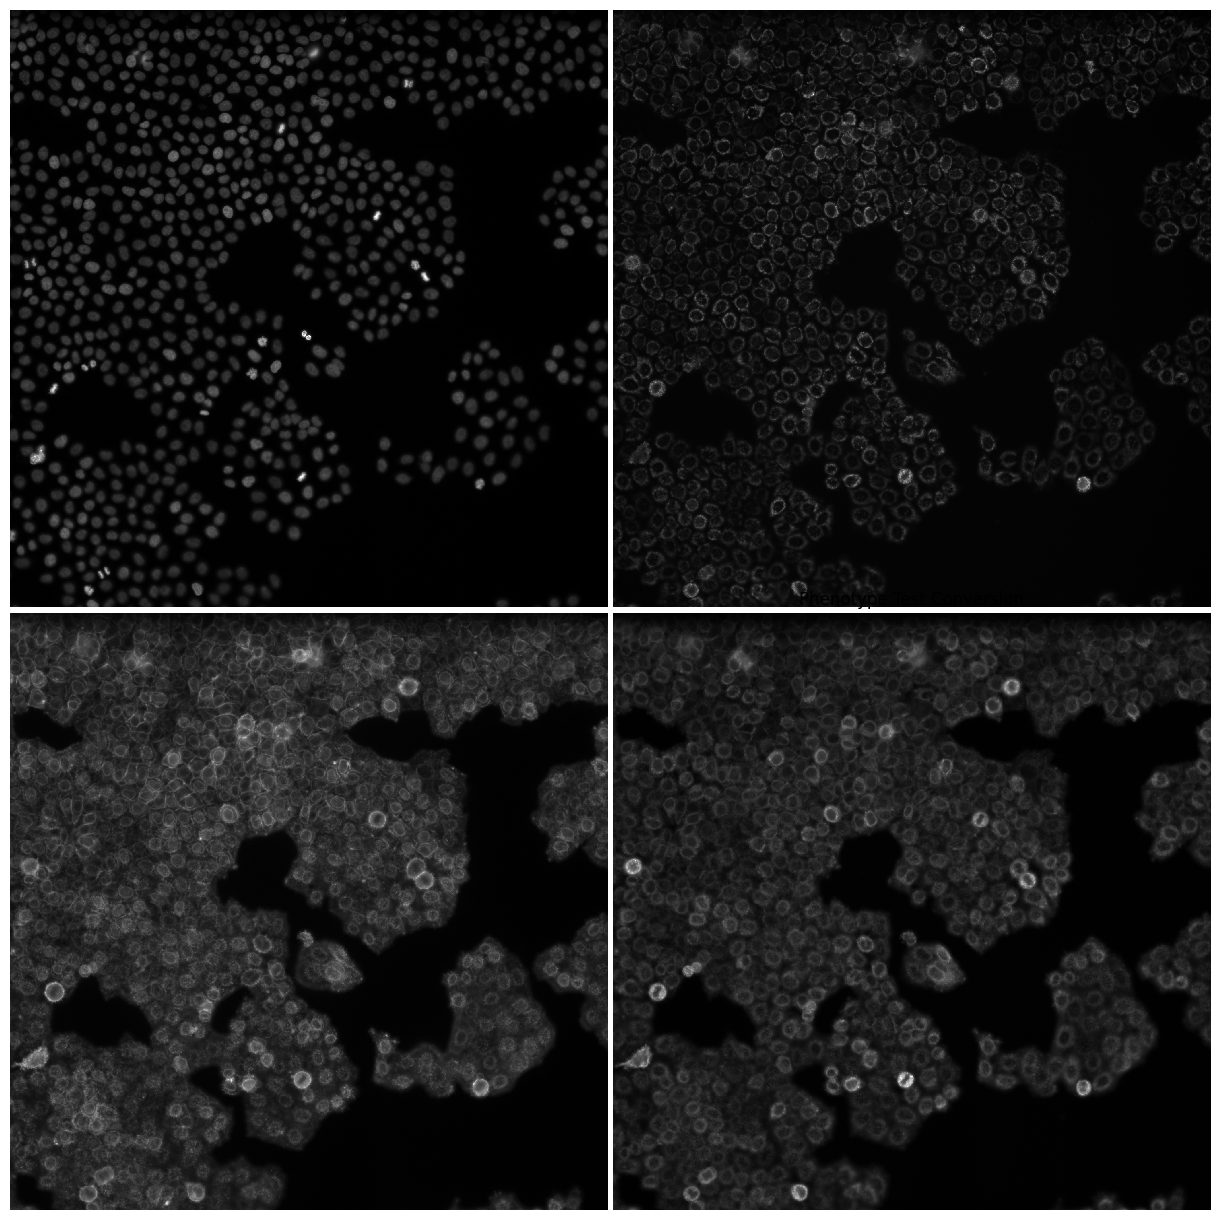

In [13]:
if len(phenotype_samples_local) > 0:
    print("Testing phenotype image conversion...")
    
    # Get sample files based on data organization
    if PHENOTYPE_DATA_ORGANIZATION == "tile":
        phenotype_sample_files = get_sample_fps(
            phenotype_samples_local,
            plate=phenotype_samples_local["plate"].iloc[0] if "plate" in phenotype_samples_local.columns else None,
            well=phenotype_samples_local["well"].iloc[0],
            tile=phenotype_samples_local["tile"].iloc[0] if "tile" in phenotype_samples_local.columns else 0,
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
    else:  # well organization
        phenotype_sample_files = get_sample_fps(
            phenotype_samples_local,
            plate=phenotype_samples_local["plate"].iloc[0] if "plate" in phenotype_samples_local.columns else None,
            well=phenotype_samples_local["well"].iloc[0],
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
    
    # Print all relevant data going into convert_to_array
    print("Phenotype sample files for conversion:")
    for fp in phenotype_sample_files:
        print(f"  {fp}")
    print("PHENOTYPE_DATA_FORMAT:", PHENOTYPE_DATA_FORMAT)
    print("PHENOTYPE_DATA_ORGANIZATION:", PHENOTYPE_DATA_ORGANIZATION)
    print("PHENOTYPE_CHANNEL_ORDER_FLIP:", PHENOTYPE_CHANNEL_ORDER_FLIP)
    print(f"PHENOTYPE_N_Z_PLANES value: {PHENOTYPE_N_Z_PLANES}")
    print(f"Type: {type(PHENOTYPE_N_Z_PLANES)}")

    # Convert using unified function
    phenotype_image = convert_to_array(
        phenotype_sample_files,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        position=0 if PHENOTYPE_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP,
        n_z_planes=PHENOTYPE_N_Z_PLANES, 
        verbose=True
    )
    
    print(f"Phenotype converted image shape: {phenotype_image.shape}")
    
    # Display images
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.title("Phenotype Test Conversion")
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [14]:
SAMPLE_FRACTION = 0.25

## Create config file with params

In [15]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
    "gcs_project": "lasagna-199723",
}

# Add preprocess section
config["preprocess"] = {
    # File paths
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    
    # SBS configuration
    "sbs_data_format": SBS_DATA_FORMAT,
    "sbs_data_organization": SBS_DATA_ORGANIZATION,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "sbs_n_z_planes": SBS_N_Z_PLANES,
    "sbs_metadata_samples_df_fp": SBS_METADATA_SAMPLES_DF_FP,
    
    # Phenotype configuration
    "phenotype_data_format": PHENOTYPE_DATA_FORMAT,
    "phenotype_data_organization": PHENOTYPE_DATA_ORGANIZATION,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "phenotype_n_z_planes": PHENOTYPE_N_Z_PLANES,
    "phenotype_metadata_samples_df_fp": PHENOTYPE_METADATA_SAMPLES_DF_FP,

    # Processing parameters
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)